## Library

In [45]:
import requests
from pathlib import Path
import logging

import pandas as pd
import plotnine as p9
import altair as alt

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

PROJECT_ROOT = Path.cwd().parents[1]
DATA_PATH = PROJECT_ROOT / "data"

## Data dictionary

### Notes

- Heatplot collection is monthly data that averaged across each ten-year period for the aggregation period. An example is monthly data for 2010-2020 averaged to get a single value for each month in that period. It only has `hicat` and `spei12` data but not `hdtrhipopdensitycat` data.
- Climatology collection is uniform period data that is averaged across the entire period. It has `hicat`, `spei12`, and `hdtrhipopdensitycat` data.
- Time series collection is monthly data for each year in the period. It has `spei12`, but not `hicat` or `hdtrhipopdensitycat` data. However, `hicat` data can be constructed based on `hi35`, `hi37`, `hi39`, and `hi41` data.


In [2]:
# Based on https://climateknowledgeportal.worldbank.org/download-data#htab-1499
data_dictionary = {
    "scenario": {
        "historical": "Historical",
        "ssp119": "SSP1-1.9",
        "ssp126": "SSP1-2.6",
        "ssp245": "SSP2-4.5",
        "ssp370": "SSP3-7.0",
        "ssp585": "SSP5-8.5",
    },
    "collection": {
        "chaz-x0.5": "Columbia HAZard Model (CHAZ, Lee et al. 2018)",
        "cmip6-x0.25": "CMIP6 0.25-degree",
        "cru-x0.5": "CRU 0.5-degree",
        "era5-x0.25": "ERA5 0.25-degree",
        "pop-x1": "Population and Poverty",
    },
    "aggregation": {
        "annual": "Annual",
        "monthly": "Monthly",
        "period": "Period",
        "seasonal": "Seasonal",
    },
    "percentiles": {
        "mean": "Mean",
        "median": "Median or 50th Percentile of the Multi-Model Ensemble",
        "p10": "10th Percentile of the Multi-Model Ensemble",
        "p90": "90th Percentile of the Multi-Model Ensemble",
    },
    "products": {
        "heatplot": {
            "label": "Heatplot",
            "description": "The heatplot shows seasonal either means or anomalies across longer-term time horizons. Monthly data is averaged across each ten-year period for the aggregation period.",
        },
        "hicat": {
            "label": "Heat Category (HICAT)",
            "description": "Heat Category (HICAT) is a classification of heat extremes based on the projected temperature anomalies.",
        },
        "tcfraction": {
            "label": "Tropical Cyclone Fraction",
            "description": "Percentage of tropical cyclones in each category relative to the total number of tropical cyclones.",
        },
        "counts": {
            "label": "Storm Count",
            "description": "Number of tropical cyclones per year in the selected cyclone category.",
        },
        "returnperiod": {
            "label": "Return Period",
            "description": "Return period of cyclones of at least the selected category.",
        },
        "trend": {
            "label": "Trend",
            "description": "The detection, estimation and prediction of trends and associated statistical and physical significance are important aspects of understanding climate and changes in climate. Trend is the rate at which change occurs over a time period. The trend may be linear or non-linear.",
        },
        "anomaly": {
            "label": "Anomaly",
            "description": "A departure from the reference value. Using temperature as an example, a positive anomaly indicates that the projected temperature was warmer than the reference value, while a negative anomaly indicates that the projected temperature was cooler than the reference value.",
        },
        "agepyramid": {
            "label": "Age Pyramid",
            "description": "A graphical illustration of the distribution of a population of a country by age groups.",
        },
        "timeseries": {
            "label": "Time Series",
            "description": "A sequence of data points, typically annual, which occur in successive order over a designated time horizon.",
        },
        "yearofchange": {
            "label": "Year of Change",
            "description": "Year of Change represents the statistically significant departure of the selected variable from the historical natural variability bounds due to the emergence of an anthropogenically forced trend.",
        },
        "percentchangecounts": {
            "label": "Percent Change in Storm Counts",
            "description": "Anomaly in annual exceedance probability (or return period) expressed as the fractional change between historical and future scenarios.",
        },
        "faep": {
            "label": "Fractional Change in Annual Exceedance Probability",
            "description": "Anomaly in annual exceedance probability calculated as fractional change (future/historical). Values less than 1 indicate decreased probability or frequency (increased return period), while values greater than 1 indicate increased probability or frequency (decreased return period).",
        },
        "fcounts": {
            "label": "Fractional Change in Storm Counts",
            "description": "Fractional change in the number of tropical cyclones per year for the selected cyclone category between historical and future scenarios.",
        },
        "freturnperiod": {
            "label": "Fractional Change in Return Period",
            "description": "Anomaly in return period expressed as the fractional change between historical and future scenarios.",
        },
        "climatology": {
            "label": "Climatology",
            "description": "The calculation of uniform periods, typically 20, 30, 50-years, consisting of annual, seasonal, and monthly, averages of temperature, precipitation, and other climatological variables.",
        },
    },
}


In [3]:
mena_countries = {
    "AFG": "Afghanistan",
    "DZA": "Algeria",
    "BHR": "Bahrain",
    "DJI": "Djibouti",
    "EGY": "Egypt",
    "IRN": "Iran",
    "IRQ": "Iraq",
    "JOR": "Jordan",
    "KWT": "Kuwait",
    "LBN": "Lebanon",
    "LBY": "Libya",
    "MAR": "Morocco",
    "OMN": "Oman",
    "QAT": "Qatar",
    "SAU": "Saudi Arabia",
    "SYR": "Syria",
    "TUN": "Tunisia",
    "ARE": "United Arab Emirates",
    "PSE": "West Bank and Gaza",
    "YEM": "Yemen",
}

## Functions

In [72]:
def fetch_climate_data(
    geocode: str,
    collection: str = "cmip6-x0.25",
    type: str = "timeseries",
    variable: str = "spei12",
    product: str = "timeseries",
    aggregation: str = "annual",
    period: str = "2015-2100",
    percentile: str = "median",
    scenario: str = "ssp119",
    model: str = "ensemble",
    model_calculation: str = "all",
    statistic: str = "mean",
) -> dict:
    """Fetch climate data from World Bank Climate Change Knowledge Portal API"""

    base_url = "https://cckpapi.worldbank.org/cckp/v1/"
    endpoint_params = [
        collection,
        type,
        variable,
        product,
        aggregation,
        period,
        percentile,
        scenario,
        model,
        model_calculation,
        statistic,
    ]
    endpoint = "_".join(endpoint_params) + f"/{geocode}"
    url = base_url + endpoint
    response = requests.get(url, params={"_format": "json"})
    return response.json()


def fetch_hicat_data(overwrite: bool = False) -> pd.DataFrame:
    """Fetch Heat Category (HICAT) data for MENA countries"""
    hicat_params = {
        "collection": "cmip6-x0.25",
        "type": "heatplot",
        "variable": "hicat",
        "product": "heatplot",
        "aggregation": "monthly",
        "period": "1951-2100",
        "percentile": "median",
        "scenario": "ssp119",
        "model": "ensemble",
        "model_calculation": "all",
        "statistic": "mean",
    }

    filename = "_".join(hicat_params.values()) + ".csv"
    hicat_file = DATA_PATH / filename
    if hicat_file.exists() and not overwrite:
        logger.info(f"Loading HICAT data from {hicat_file}")
        return pd.read_csv(hicat_file)

    logger.info("Fetching HICAT subnational data for MENA region")
    hicat_df = pd.DataFrame(
        fetch_climate_data(geocode="region_mea", **hicat_params)["data"]
    )

    hicat_df = (
        hicat_df.reset_index()
        .rename(columns={"index": "year"})
        .melt(id_vars=["year"], var_name="country", value_name="heat_category")
        .assign(**hicat_params)
    )
    hicat_df.to_csv(hicat_file, index=False)
    logger.info(f"Saved HICAT data to {hicat_file}")
    return hicat_df


def fetch_spei12_data(overwrite: bool = False) -> pd.DataFrame:
    """Fetch SPEI-12 data for MENA countries"""

    # spei12_params = {
    #     "collection": "cmip6-x0.25",
    #     "type": "heatplot",
    #     "variable": "spei12",
    #     "product": "heatplot",
    #     "aggregation": "monthly",
    #     "period": "1951-2100",
    #     "percentile": "median",
    #     "scenario": "ssp119",
    #     "model": "ensemble",
    #     "model_calculation": "all",
    #     "statistic": "mean",
    # }

    spei12_params = {
        "collection": "cmip6-x0.25",
        "type": "timeseries",
        "variable": "spei12",
        "product": "timeseries",
        "aggregation": "annual",
        "period": "2015-2100",
        "percentile": "median",
        "scenario": "ssp119",
        "model": "ensemble",
        "model_calculation": "all",
        "statistic": "mean",
    }

    filename = "_".join(spei12_params.values()) + ".csv"
    spei12_file = DATA_PATH / filename
    if spei12_file.exists() and not overwrite:
        logger.info(f"Loading SPEI-12 data from {spei12_file}")
        return pd.read_csv(spei12_file)

    logger.info("Fetching SPEI-12 data for MENA region")
    spei12_df = pd.DataFrame(
        fetch_climate_data(geocode="region_mea", **spei12_params)["data"]
    )

    spei12_df = (
        spei12_df.reset_index()
        .rename(columns={"index": "year"})
        .melt(id_vars=["year"], var_name="country", value_name="spei12")
        .assign(**spei12_params)
    )
    spei12_df.to_csv(spei12_file, index=False)
    logger.info(f"Saved SPEI-12 data to {spei12_file}")
    return spei12_df

## Preprocessing

In [88]:
hicat = fetch_hicat_data()
spei12 = fetch_spei12_data()

INFO:__main__:Loading HICAT data from /Users/farhanreynaldo/Documents/world-bank/git-repo/MENA-FCV-economic-monitor/data/cmip6-x0.25_heatplot_hicat_heatplot_monthly_1951-2100_median_ssp119_ensemble_all_mean.csv
INFO:__main__:Loading SPEI-12 data from /Users/farhanreynaldo/Documents/world-bank/git-repo/MENA-FCV-economic-monitor/data/cmip6-x0.25_timeseries_spei12_timeseries_annual_2015-2100_median_ssp119_ensemble_all_mean.csv


In [89]:
def exclude_countries(df):
    """Exclude specific countries from the DataFrame"""
    exclude_countries = ["ISR", "MLT"]
    query = "|".join(exclude_countries)
    return df.loc[~df["country"].str.contains(query, regex=True, na=False)]


spei12_ts = spei12.assign(
    year_month=lambda df: pd.to_datetime(df["year"].astype(str) + "-01-01"),
    year=lambda df: df["year_month"].dt.year,
).pipe(exclude_countries)

## Visualization

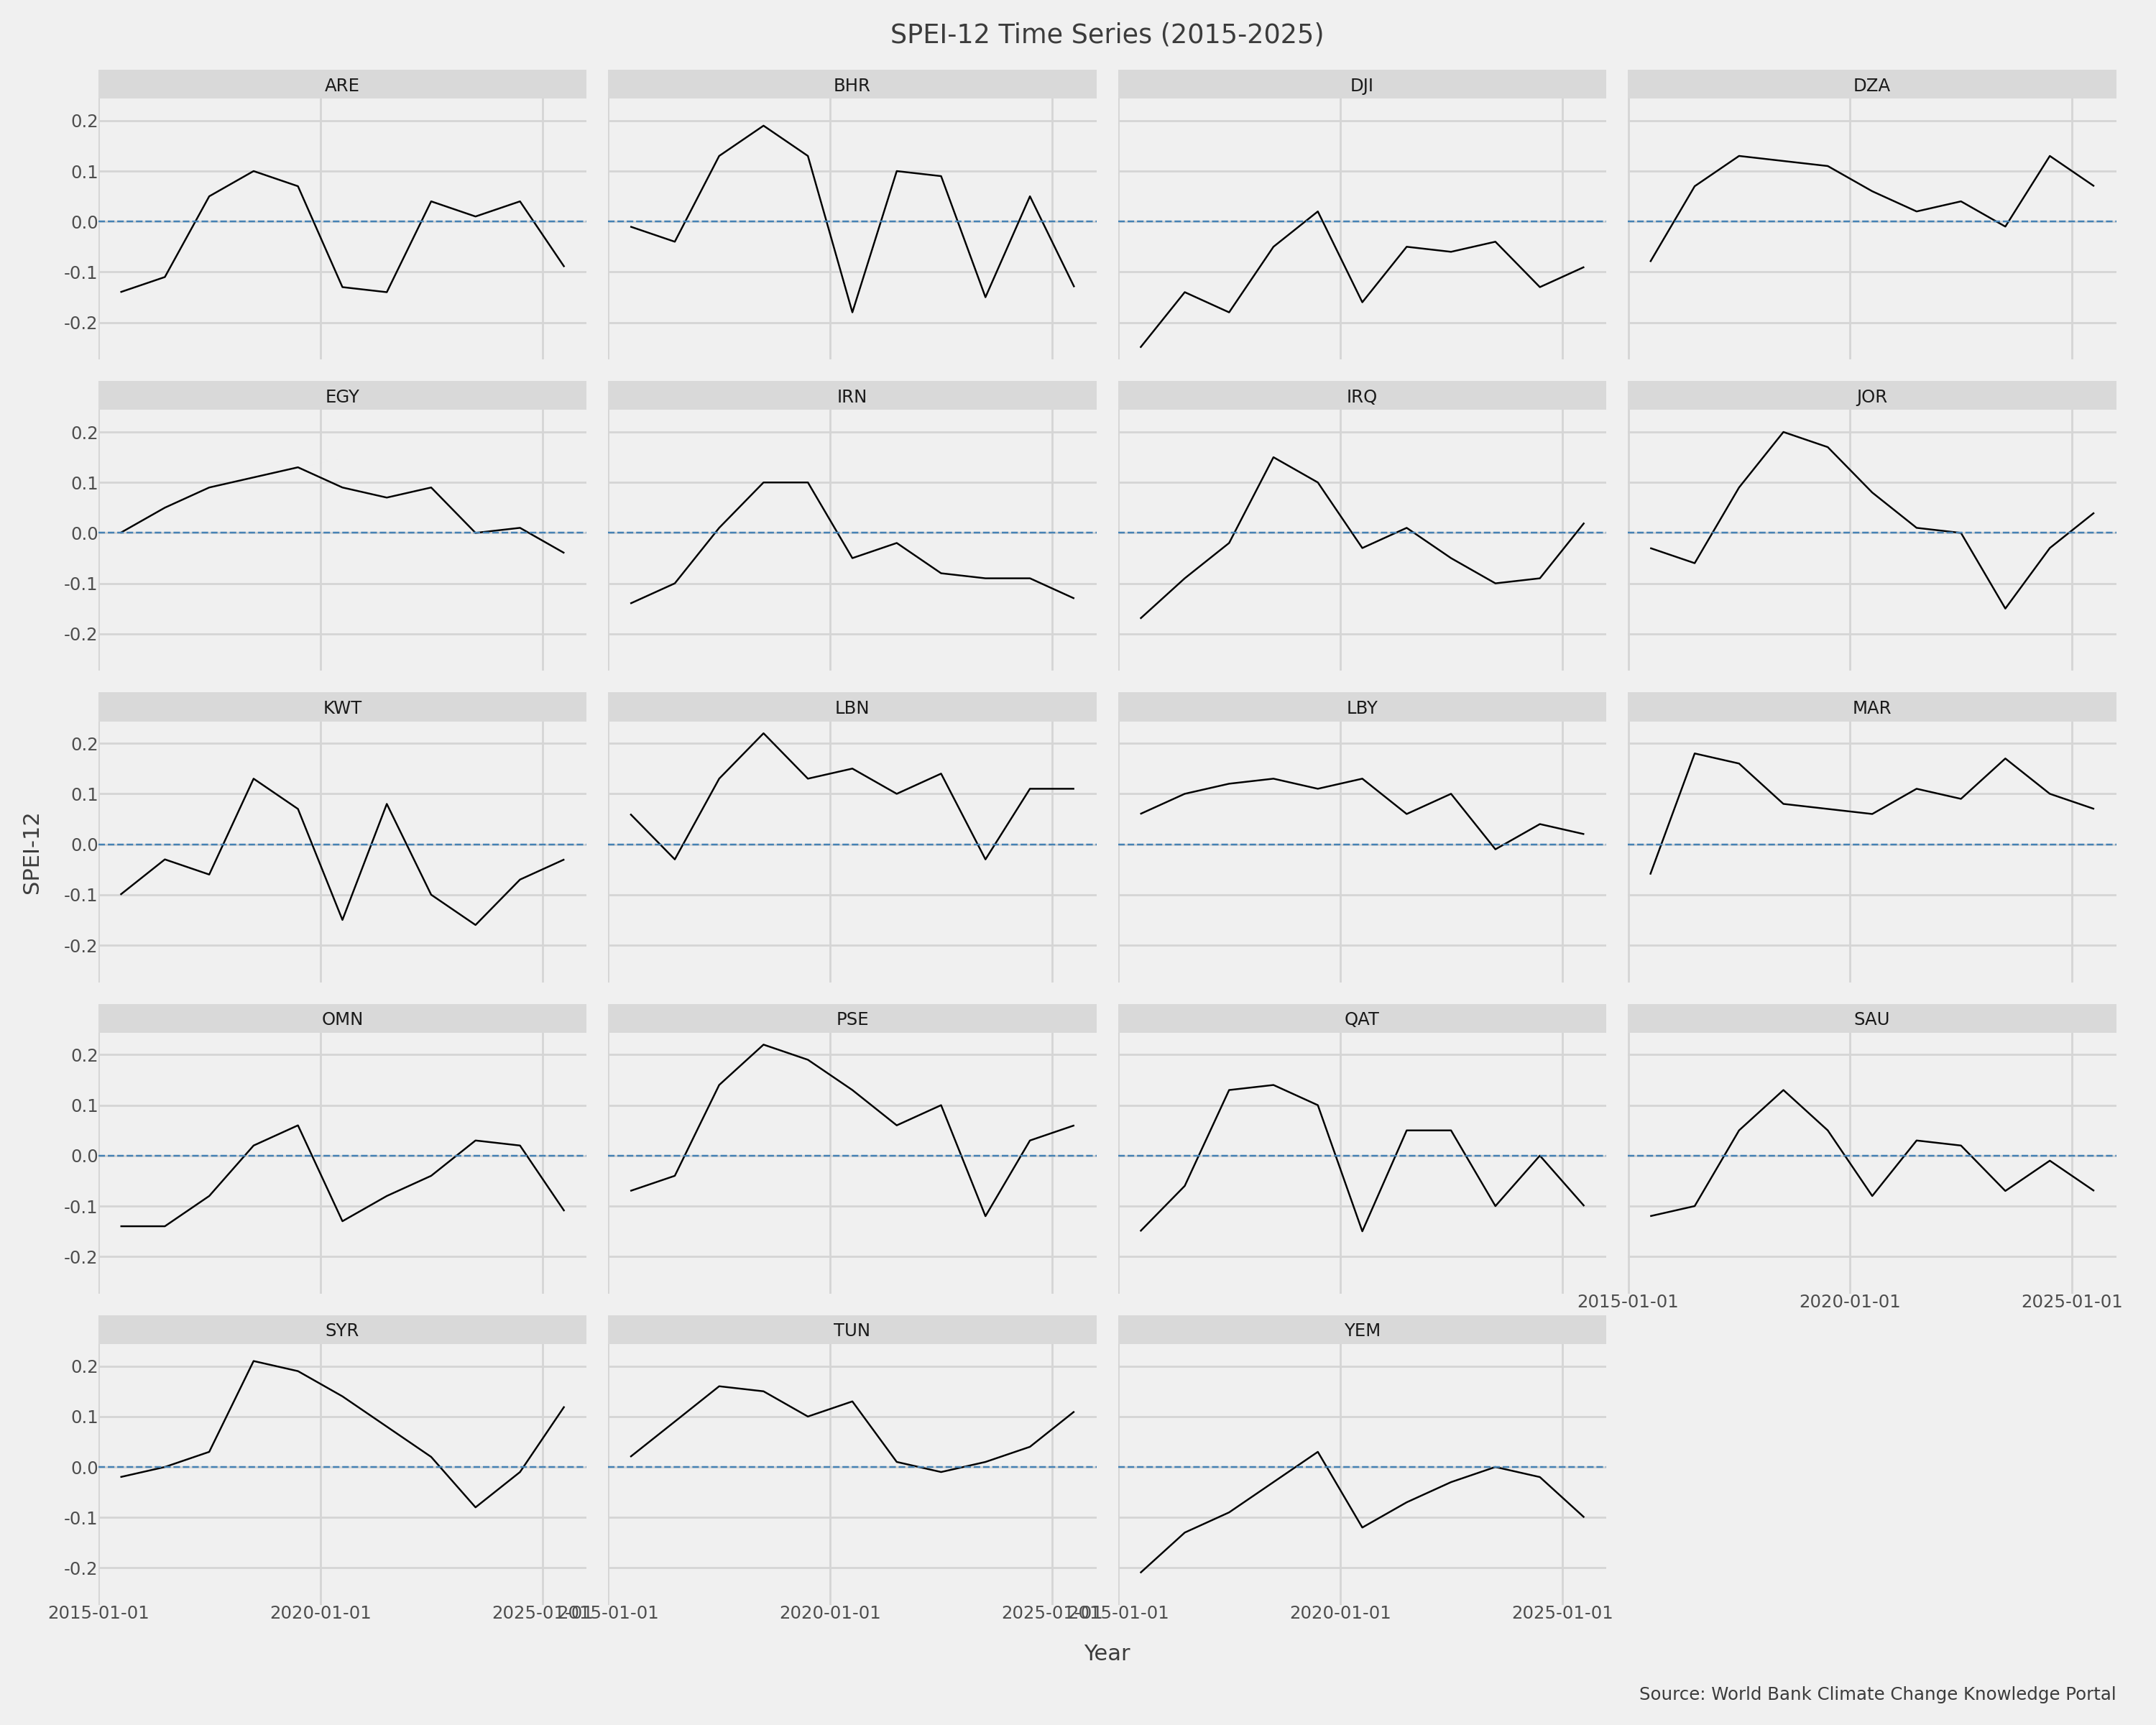

In [86]:
(
    spei12_ts.query("year >= 2015 & year <= 2025")
    .loc[lambda df: ~df["country"].str.contains(r"\.", regex=True)]
    .pipe(p9.ggplot)
    + p9.aes(x="year_month", y="spei12")
    + p9.geom_line()
    + p9.geom_hline(yintercept=0, linetype="dashed", color="steelblue")
    + p9.facet_wrap("~country", ncol=4)
    + p9.labs(
        title="SPEI-12 Time Series (2015-2025)",
        x="Year",
        y="SPEI-12",
        caption="Source: World Bank Climate Change Knowledge Portal",
    )
    + p9.theme_538()
    + p9.theme(figure_size=(15, 12))
)

In [ ]:
(
    spei12_ts.query("year >= 2015 & year <= 2025")
    .loc[lambda df: ~df["country"].str.contains(r"\.", regex=True)]
    .pipe(alt.Chart)
    .mark_line()
    .encode(
        x="year",
        y="spei12",
        facet=alt.Facet("country", columns=3),
        tooltip=["year", "spei12", "country"],
    )
    .properties(width=400, height=300)
    .interactive()
)

alt.Chart(...)